In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data269


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [3]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 14.4MB/s eta 0:00:01


In [5]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def sigmoid(x):
     # sigmoid激活函数
     return 1/(1+np.exp(-x))

def dsigmoid(x):
     # sigmoid激活函数的导数
     return x*(1-x)

def load_data():
     # 从文件导入数据
     datafile = './data/housing.data'
     data = np.fromfile(datafile, sep=' ')

     # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
     feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
     'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
     feature_num = len(feature_names)

     # 将原始数据进行Reshape，变成[N, 14]这样的形状
     data = data.reshape([data.shape[0] // feature_num, feature_num])

     # 将原数据集拆分成训练集和测试集
     # 这里使用70%的数据做训练，30%的数据做测试
     # 测试集和训练集必须是没有交集的
     ratio = 0.7
     offset = int(data.shape[0] * ratio)
     training_data = data[:offset]

     # 计算训练集的最大值，最小值，平均值
     maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]

     # 记录数据的归一化参数，在预测时对数据做归一化
     global max_values
     global min_values
     global avg_values
     max_values = maximums
     min_values = minimums
     avg_values = avgs

     # 对数据进行归一化处理
     for i in range(feature_num):
         #print(maximums[i], minimums[i], avgs[i])
         data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

     # 训练集和测试集的划分比例
     training_data = data[:offset]
     test_data = data[offset:]
     return training_data, test_data

In [101]:
class Network(object):
    def __init__(self, num_of_weights,hidden_sum):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w_1 = np.random.randn(num_of_weights, hidden_sum)  # 第一个全连接层的网络参数
        self.b_1 = np.zeros(hidden_sum)
        self.w_2 = np.random.randn(hidden_sum,1)                # 第二个全连接层的网络参数
        self.b_2 = 0.

    def forward(self, x):
        # 前向传播
        z = np.dot(x, self.w_1) + self.b_1     # 全连接层
        z = sigmoid(z)                         # sigmoid激活层
        z = np.dot(z, self.w_2) + self.b_2     # 全连接层
        return z

    def loss(self, z, y):
        # 均方差损失函数计算
        error = z - y
        cost = error * error
        cost = np.mean(cost) / 2
        return cost

    def gradient(self, x, y):
        # 梯度计算
        o_1 = sigmoid(np.dot(x, self.w_1) + self.b_1)    # 第一个全连接层的输出
        z = self.forward(x)                              # 第二个全连接层的输出

        gradient_w_1 = x.T.dot((z-y).dot(self.w_2.T) * dsigmoid(o_1))           # 第一个全连接层参数的梯度
        gradient_b_1 = np.mean((z-y).dot(self.w_2.T) * dsigmoid(o_1), axis=0) 

        # gradient_w_2 = o_1.T.dot((z-y))
        gradient_w_2 = np.mean((z-y)*o_1,axis=0)                                # 第二个全连接层参数的梯度
        gradient_w_2 = gradient_w_2[:,np.newaxis]
        gradient_b_2 = np.mean((z-y))
        return gradient_w_1, gradient_b_1, gradient_w_2, gradient_b_2

    def update(self, gradient_w_1, gradient_w_2, gradient_b_1, gradient_b_2, eta = 0.01):
        # 梯度下降，网络参数更新
        self.w_1 = self.w_1 - eta * gradient_w_1
        self.b_1 = self.b_1 - eta * gradient_b_1
        self.w_2 = self.w_2 - eta * gradient_w_2
        self.b_2 = self.b_2 - eta * gradient_b_2


    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]   # 特征
                y = mini_batch[:, -1:]   # 标签
                a = self.forward(x)      # 网络输出
                loss = self.loss(a, y)   # 网络损失
                gradient_w_1, gradient_b_1, gradient_w_2, gradient_b_2 = self.gradient(x, y)  # 参数梯度
                self.update(gradient_w_1, gradient_w_2, gradient_b_1, gradient_b_2, eta)      # 更新参数
                losses.append(loss)                                                           # 记录损失
                # print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                #                 format(epoch_id, iter_id, loss))

        return losses

    def test(self,test_data):
        x = test_data[:, :-1]   # 特征
        y = test_data[:, -1:]   # 标签
        a = self.forward(x)      # 网络输出
        loss = self.loss(a, y)   # 网络损失
        print('The testing loss = {:.4f}'.format(loss))
        a = a.reshape([1,-1])
        y = y.reshape([1,-1])
        plt.plot(np.arange(y.shape[1]),np.squeeze(y),'b', label = 'label') #标签数据
        plt.plot(np.arange(a.shape[1]),np.squeeze(a),'r', label = 'predict') #预测结果
        plt.xlabel("x")
        plt.ylabel('y')
        plt.legend(loc="upper right")   #显示图中的标签
        plt.show()

    def eval(self,test_data):
        idx = -12
        # idx = np.random.randint(0, test_data.shape[0])
        one_data, label = test_data[idx, :-1], test_data[idx, -1]
        one_data =  one_data.reshape([1,-1])      # 修改该条数据shape为[1,13]


        predict = self.forward(one_data)
        predict = np.squeeze(predict)   # 去除冗余维度
        loss = self.loss(predict, label)

        # 对predict做反归一化处理
        predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
        # 对label做反归一化处理
        label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

        print("Predict result is {}, the corresponding label is {}, the loss is {}".format(predict, label, loss))

The testing loss = 0.0471
Predict result is 34.227041155430484, the corresponding label is 37.75593220338986, the loss is 0.004266971858079505


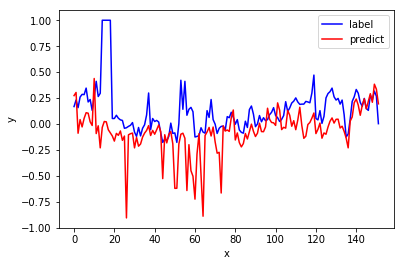

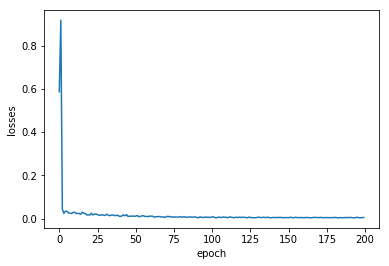

In [102]:
if __name__ == '__main__':
     # 获取数据
     train_data, test_data = load_data()

     # 创建网络
     net = Network(13,10)   # 隐层节点数15

     # 启动训练
     # mini_batch,batch_size=100,learning_rate=0.1
     losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.1)  
     net.test(test_data)  # 测试集的效果
     net.eval(test_data)  # 单条数据效果验证

     # 画出损失函数的变化趋势
     plot_x = np.arange(len(losses))
     plot_y = np.array(losses)
     plt.plot(plot_x, plot_y)
     plt.xlabel("epoch")
     plt.ylabel('losses')
     plt.show()